### Imports

In [14]:
import numpy as np
import random
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

### Configuração do Problema do Caixeiro Viajante

In [15]:
# Lê o CSV contendo os pontos (as colunas devem ser 3 coordenadas numéricas)
# Exemplo esperado de CSV:
# x,y,z
# 10,5,3
# -2,4,8
# ...
df = pd.read_csv("CaixeiroGrupos.csv")

POINTS = df.iloc[:, :3].values

# Quantidade de pontos
N_INTEREST_POINTS = len(POINTS)

# O ponto de origem agora é o primeiro ponto do CSV
ORIGIN_POINT = POINTS[0]

# ===============================
# 2. Mapa de Distâncias (Função utilitária)
# ===============================
def calculate_distance(p1, p2):
    """Calcula a distância euclidiana 3D entre dois pontos."""
    return np.sqrt(np.sum((p1 - p2)**2))

# ===============================
# 3. Função de Custo (Objetivo)
# ===============================
def route_cost(route, points):
    """
    Calcula o custo total da rota (distância total).
    A rota é uma sequência de índices dos pontos, começando e terminando na Origem (ponto 0).
    Exemplo de rota: [0, 5, 20, 15, 0]
    """
    total_distance = 0
    
    for i in range(len(route) - 1):
        point_a_index = route[i]
        point_b_index = route[i+1]
        total_distance += calculate_distance(points[point_a_index], points[point_b_index])
        
    return total_distance

# ===============================
# 4. Função de Fitness (GA)
# ===============================
def fitness_tsp(route, points):
    """Função de Aptidão (Fitness) para Maximização. Inversa do Custo."""
    cost = route_cost(route, points)
    return 1.0 / (1.0 + cost)

# ===============================
# 5. Hiperparâmetros GA
# ===============================
N_INDIVIDUALS = 50
MAX_GENERATIONS = 200
P_RECOMBINATION = 0.85
P_MUTATION = 0.01
N_TOURNAMENT = 2


### Implementação do Algoritmo Genético (GA)

In [16]:
class GeneticAlgorithmTSP:
    def __init__(self, points, n_individuals, max_generations, p_recombination, p_mutation, n_tournament):
        self.points = points
        self.N_points = points.shape[0]  # Inclui a Origem (índice 0)
        self.n_individuals = n_individuals
        self.max_generations = max_generations
        self.p_recombination = p_recombination
        self.p_mutation = p_mutation
        self.n_tournament = n_tournament
        self.history_best_cost = []
        
        # O cromossomo é a sequência de pontos a serem visitados (índices de 1 a N_pontos-1)
        self.visit_indices = np.arange(1, self.N_points)  # [1, 2, ..., N-1]

        # Inicialização da População
        self.population = self._initialize_population()
        self.best_global_route = self.population[0]
        self.best_global_cost = route_cost(self.best_global_route, self.points)
        
    def _initialize_population(self):
        """Gera N_INDIVIDUOS rotas aleatórias (permutações)"""
        population = []
        for _ in range(self.n_individuals):
            random_route = np.random.permutation(self.visit_indices)
            # Adicionar a Origem (0) no início e no fim
            chromosome = np.concatenate(([0], random_route, [0]))
            population.append(chromosome)
        return population

    # --- Operadores Genéticos ---
    
    def _tournament_selection(self, fitness_values):
        """Seleciona um pai usando o método do Torneio."""
        
        # Seleciona N_TORNEIO indivíduos aleatórios
        tournament_indices = random.choices(range(self.n_individuals), k=self.n_tournament)
        
        # Encontra o índice do melhor indivíduo no torneio
        best_index = tournament_indices[0]
        best_fitness = fitness_values[best_index]
        
        for idx in tournament_indices[1:]:
            if fitness_values[idx] > best_fitness:
                best_fitness = fitness_values[idx]
                best_index = idx
                
        return self.population[best_index]

    def _two_point_order_crossover(self, parent1, parent2):
        """
        Recombinação de Dois Pontos que evita repetição (Order Crossover - OX)
        Garante que a rota interna (sem os 0s) seja uma permutação. [cite: 1922, 1923, 1924]
        """
        # Ignora os pontos de origem (0) para a recombinação
        genotype1 = parent1[1:-1]
        genotype2 = parent2[1:-1]
        L = len(genotype1)
        
        # Seleciona os dois pontos de corte aleatoriamente (índices no genótipo)
        cut1, cut2 = sorted(random.sample(range(L), 2))
        
        # 1. Propagar a seção selecionada nos filhos [cite: 1924]
        child1_middle = genotype1[cut1:cut2]
        child2_middle = genotype2[cut1:cut2]
        
        # Inicializa os genes restantes com -1
        child1_genes = np.full(L, -1)
        child2_genes = np.full(L, -1)
        child1_genes[cut1:cut2] = child1_middle
        child2_genes[cut1:cut2] = child2_middle
        
        # 2. Completar a sequência com os demais pontos sem repetição [cite: 1924]
        
        # Para o Filho 1, começar a preencher a partir do corte2, usando a ordem do Pai 2
        p2_fill_order = np.concatenate((genotype2[cut2:], genotype2[:cut2]))
        
        idx_c1 = cut2
        for gene in p2_fill_order:
            if gene not in child1_middle:
                if idx_c1 >= L:  # Volta para o início se ultrapassar o fim
                    idx_c1 = 0
                child1_genes[idx_c1] = gene
                idx_c1 += 1
                
        # Para o Filho 2, usar a ordem do Pai 1
        p1_fill_order = np.concatenate((genotype1[cut2:], genotype1[:cut2]))
        
        idx_c2 = cut2
        for gene in p1_fill_order:
            if gene not in child2_middle:
                if idx_c2 >= L:
                    idx_c2 = 0
                child2_genes[idx_c2] = gene
                idx_c2 += 1

        # Adicionar a Origem (0) no início e no fim para a rota completa (cromossomo)
        child1 = np.concatenate(([0], child1_genes, [0]))
        child2 = np.concatenate(([0], child2_genes, [0]))
        
        return child1, child2

    def _swap_mutation(self, chromosome):
        """
        Mutação que faz a troca de dois genes (pontos de visita) dentro da sequência.
        Aplica a mutação na prole com probabilidade P_MUTACAO[cite: 1927].
        """
        # A mutação deve ser aplicada apenas nos genes passíveis de mudança (pontos de visita) [cite: 1910]
        genotype = chromosome[1:-1]
        
        if random.random() < self.p_mutation:
            # Escolhe dois índices aleatórios no genótipo e troca 
            idx1, idx2 = random.sample(range(len(genotype)), 2)
            genotype[idx1], genotype[idx2] = genotype[idx2], genotype[idx1]
            
        # Retorna a rota completa
        return np.concatenate(([0], genotype, [0]))
    
    # --- Execução Principal ---
    
    def search(self):
        for generation in range(self.max_generations):
            # 1. Avaliação
            costs = np.array([route_cost(route, self.points) for route in self.population])
            fitness_values = 1.0 / (1.0 + costs)  # Função de Aptidão (inversa do custo)
            
            # Atualiza o melhor global
            best_index_pop = np.argmax(fitness_values)
            best_generation_cost = costs[best_index_pop]
            
            if best_generation_cost < self.best_global_cost:
                self.best_global_cost = best_generation_cost
                self.best_global_route = self.population[best_index_pop]
            
            self.history_best_cost.append(self.best_global_cost)
            
            # Critério de parada antecipada [cite: 1929]
            # Implementação simplificada: critério de parada é o máximo de gerações.

            # 2. Criação da Nova População
            new_population = []
            
            # Elitismo [cite: 1341, 1931]
            best_idx = np.argmin(costs)
            elite_route = self.population[best_idx]
            new_population.append(elite_route)
            
            while len(new_population) < self.n_individuals:
                # 3. Seleção de Pais
                parent1 = self._tournament_selection(fitness_values)
                parent2 = self._tournament_selection(fitness_values)
                
                child1, child2 = parent1, parent2  # Inicializa com cópias dos pais
                
                # 4. Recombinação
                if random.random() < self.p_recombination:
                    child1, child2 = self._two_point_order_crossover(parent1, parent2)
                    
                # 5. Mutação
                child1_mut = self._swap_mutation(child1)
                child2_mut = self._swap_mutation(child2)
                
                # Adiciona à nova população
                new_population.append(child1_mut)
                if len(new_population) < self.n_individuals:
                    new_population.append(child2_mut)

            self.population = new_population
        
        return self.best_global_route, self.best_global_cost

### Execução do algoritimo e Resultados

--- Resultados Algoritmo Genético (TSP 3D com 50 pontos) ---
Melhor Custo Encontrado: 1049.7010
Melhor Rota (índices): [ 0 17 11 23 40 31 16 44 35 45 26 34  6 21 12  3 15 28 48 13 49 43  1 27
  4 10 41 33 36 19 32 42 25  8 18  9 22  2 24 37 30 14 47  7  5 20 38 29
 39 46  0]
Gerações Realizadas: 200


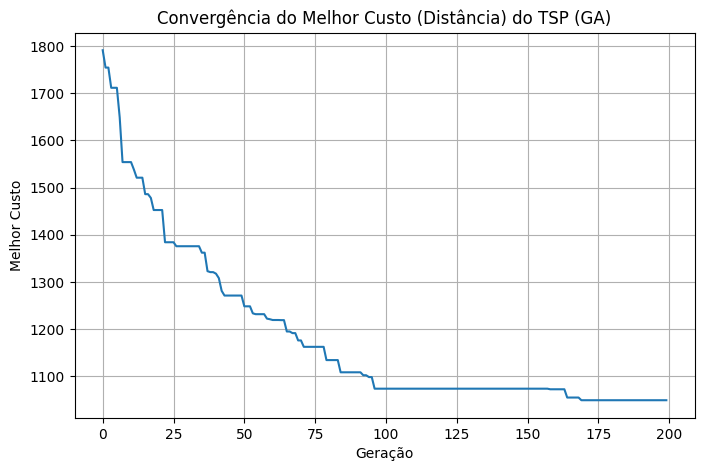


--- Análise da Moda (20 Rodadas) ---
Moda de Gerações para Solução Aceitável (Estagnação por 50 gens): 200 (Frequência: 7)
Moda do Custo Final (Arredondado): 1009.36 (Frequência: 1)

--- Análise Qualitativa do Elitismo ---
O operador de elitismo (N_e=1, mantendo o melhor da geração) foi **incluído** no loop de criação da nova população.
Isso garante que a melhor solução encontrada até o momento nunca seja perdida.
A análise da curva de convergência (gráfico) sugere que o elitismo é **necessário** para problemas combinatórios, pois a rota total tem tendência a ser reduzida de forma monotônica, indicando que o melhor indivíduo está sendo mantido e explorado a cada geração.


In [ ]:
## Execução e Análise do GA

# 1. Execução
ga = GeneticAlgorithmTSP(
    POINTS, 
    N_INDIVIDUALS, 
    MAX_GENERATIONS, 
    P_RECOMBINATION, 
    P_MUTATION, 
    N_TOURNAMENT
)
best_route, best_cost = ga.search()

print(f"--- Resultados Algoritmo Genético (TSP 3D com {N_INTEREST_POINTS} pontos) ---")
print(f"Melhor Custo Encontrado: {best_cost:.4f}")
print(f"Melhor Rota (índices): {best_route}")
print(f"Gerações Realizadas: {MAX_GENERATIONS}")

# 2. Visualização do Histórico do Custo
plt.figure(figsize=(8, 5))
plt.plot(ga.history_best_cost)
plt.title(f'Convergência do Melhor Custo (Distância) do TSP (GA)')
plt.xlabel('Geração')
plt.ylabel('Melhor Custo')
plt.grid(True)
plt.show()

# 3. Análise da Moda de Gerações (Execução Múltipla) 

ROUNDS_MODE = 20
THRESHOLD_ACCEPTABLE_GENERATION = 50 # Definindo T como 50 para o critério de estagnação.

convergence_generations = []
final_costs = []

def found_acceptable_solution(cost_history, stagnation_generations_t):
    """
    Critério de parada: quando não há melhoria na solução x_best a cada t iterações. [cite: 1730]
    Retorna a geração em que a melhoria parou por stagnation_generations_t vezes.
    """
    if len(cost_history) < stagnation_generations_t:
        return len(cost_history)
        
    for i in range(len(cost_history) - stagnation_generations_t):
        # Verifica se o custo se manteve o mesmo nas últimas t iterações
        if np.all(np.array(cost_history[i:i + stagnation_generations_t]) == cost_history[i]):
            return i + stagnation_generations_t
    return len(cost_history) # Não estagnou

for r in range(ROUNDS_MODE):
    ga_r = GeneticAlgorithmTSP(
        POINTS, 
        N_INDIVIDUALS, 
        MAX_GENERATIONS, 
        P_RECOMBINATION, 
        P_MUTATION, 
        N_TOURNAMENT
    )
    _, final_cost = ga_r.search()
    final_costs.append(round(final_cost, 2))
    
    # Encontra a geração em que a solução aceitável (estagnação) foi encontrada
    acceptable_generation = found_acceptable_solution(ga_r.history_best_cost, THRESHOLD_ACCEPTABLE_GENERATION)
    convergence_generations.append(acceptable_generation)


mode_generations = Counter(convergence_generations).most_common(1)[0]
mode_costs = Counter(final_costs).most_common(1)[0]

print("\n--- Análise da Moda (20 Rodadas) ---")
print(f"Moda de Gerações para Solução Aceitável (Estagnação por {THRESHOLD_ACCEPTABLE_GENERATION} gens): {mode_generations[0]} (Frequência: {mode_generations[1]})")
print(f"Moda do Custo Final (Arredondado): {mode_costs[0]} (Frequência: {mode_costs[1]})")

# 4. Análise do Elitismo (Qualitativa) [cite: 1931]
print("\n--- Análise Qualitativa do Elitismo ---")
print(f"O operador de elitismo (N_e=1, mantendo o melhor da geração) foi **incluído** no loop de criação da nova população.")
print(f"Isso garante que a melhor solução encontrada até o momento nunca seja perdida.")
print(f"A análise da curva de convergência (gráfico) sugere que o elitismo é **necessário** para problemas combinatórios, pois a rota total tem tendência a ser reduzida de forma monotônica, indicando que o melhor indivíduo está sendo mantido e explorado a cada geração.")